# Introduction

In the [burned-up_area_modelling](./burned-up_area_modelling.ipynb) notebook we have trained a model that classifies the pixel data as burned-up (e.g., after forest fire), using a combination of tasks from `eo-learn`. 

In this notebook, we will construct a typical Earth Observation workflow using [`eo-grow`](https://github.com/sentinel-hub/eo-grow.git), and run it on larger area using the model we have trained before.

The workflow is depicted in the image below:

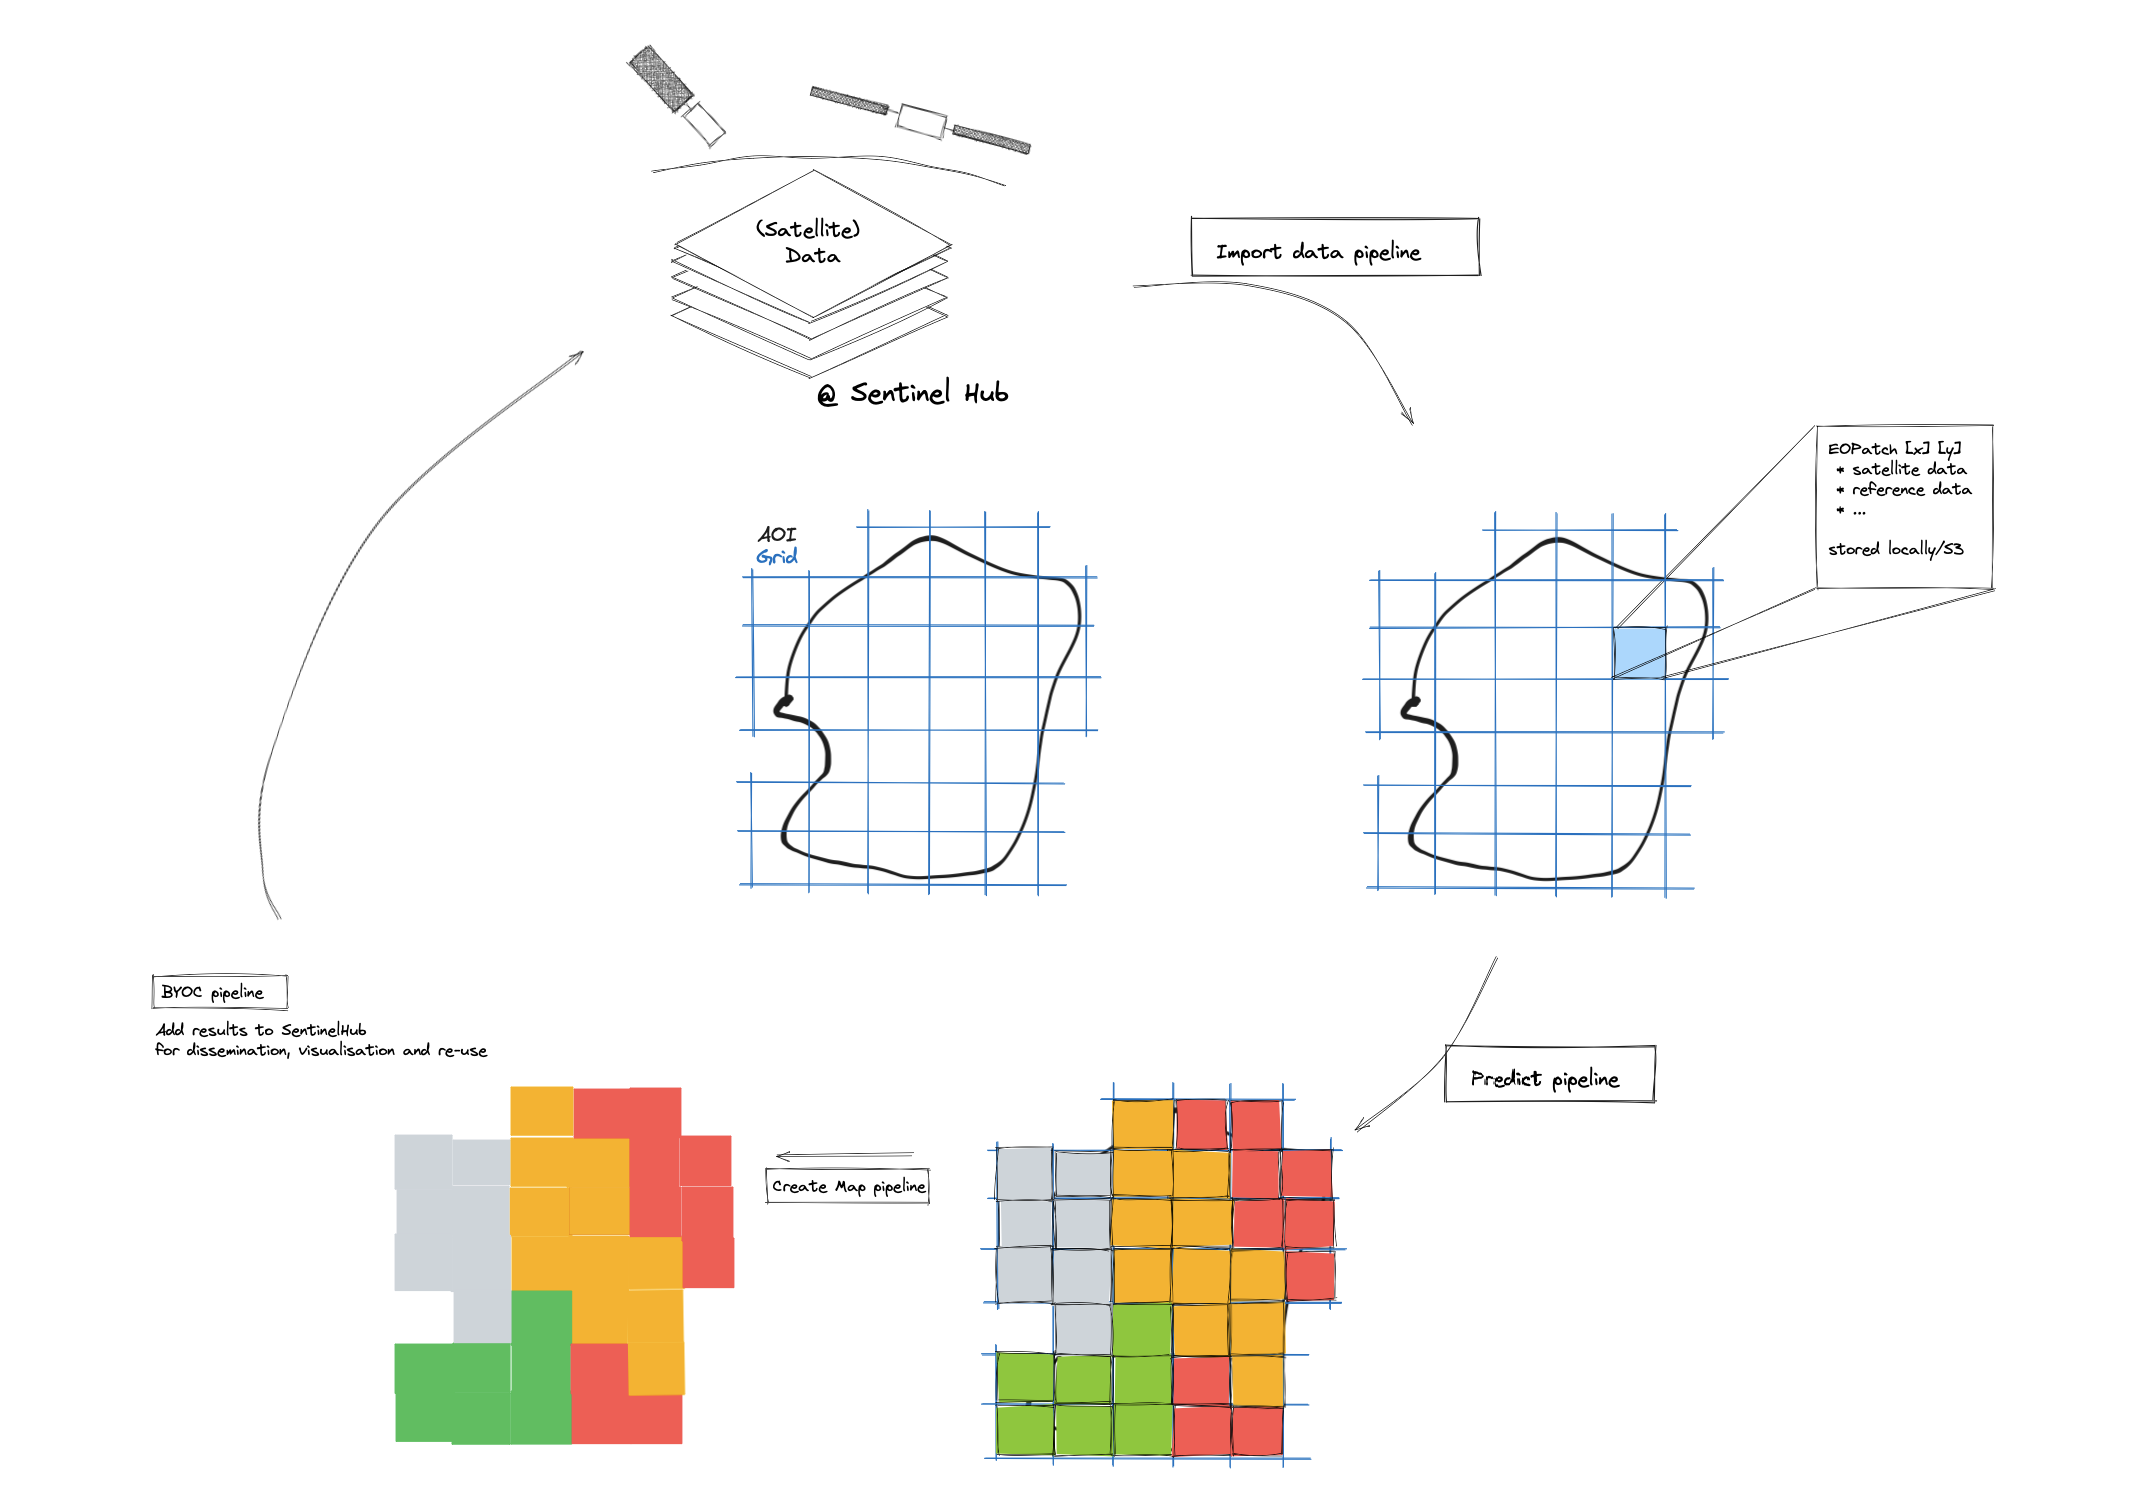

### Installation / upgrade of eo-grow to latest version

If you are running the notebook for the first time, and haven't installed the `eo-grow` package yet, uncomment and run the cell below.

In [1]:
# !pip install eo-grow

### Imports

In [2]:
%matplotlib inline

import os
import warnings
from typing import Any, Dict

import fs
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fs.base import FS
from utils import PatchToDataframeTask

from eogrow.core.config import RawConfig, interpret_config_from_dict, recursive_config_join
from eogrow.core.storage import StorageManager
from eogrow.pipelines.download import DownloadEvalscriptPipeline
from eogrow.pipelines.export_maps import ExportMapsPipeline
from eogrow.pipelines.prediction import BasePredictionPipeline
from eolearn.core import EONode, EOPatch, EOTask, ExtractBandsTask, FeatureType, RemoveFeatureTask
from eolearn.core.types import Feature
from eolearn.core.utils.fs import pickle_fs, unpickle_fs
from sentinelhub import DataCollection

warnings.filterwarnings("ignore")

### Some helper functions

In [3]:
def prepare_config(global_config: Dict[str, Any], pipeline_config: Dict[str, Any]) -> RawConfig:
    joint_config = recursive_config_join(pipeline_config, global_config)
    return interpret_config_from_dict(joint_config)

## Running the pipelines

### Define area of interest (AOI)

For this example the AOI is covering Karst region in Slovenia, which was affected by a severe fires in summer of 2022.   
The AOI is stored in `demo_aoi.geojson`, and is specified as input parameter in the `AreaManager` part of the global config (below).

### Config with global parameters

The main configuration parameters are defined here: a folder, where everything (data, model, results, ...) will be stored. In this case, the project folder is local path; it could also be a path on object storage (AWS S3). As it is local, one can also copy the notebook and corresponding files under `project` to local machine and run things there.  

In [4]:
PROJECT_FOLDER = os.path.join(os.path.abspath(os.path.curdir), "eogrow_project")

In [5]:
storage_config = {
    "manager": "eogrow.core.storage.StorageManager",
    "project_folder": PROJECT_FOLDER,
    "structure": {
        "data": "data",
        "predictions": "predictions",
        "models": "models",
        "maps": "maps",
    },
}

area_config = {
    "manager": "eogrow.core.area.utm.UtmZoneAreaManager",
    "geometry_filename": "area.geojson",
    "patch": {
        "size_x": 10000,
        "size_y": 10000,
    },
}

logging_config = {
    "manager": "eogrow.core.logging.LoggingManager",
    "save_logs": True,
    "show_logs": True,
    "capture_warnings": False,
}

global_config = {"storage": storage_config, "area": area_config, "logging": logging_config}

In [6]:
storage_manager = StorageManager.from_raw_config(storage_config)

### Download pipeline

As for this demonstration we are not using object storage (AWS S3), we will be requesting data through Sentinel Hub ProcessingAPI. When relying on object storage, we could have used the BatchAPI and corresponding `eogrow.pipelines.batch_download.BatchDownloadPipeline`.

This pipeline takes care of the first step in literally any EO workflow: getting the data.

In [7]:
download_config = {
    "pipeline": "eogrow.pipelines.download.DownloadEvalscriptPipeline",
    "data_collection": "SENTINEL2_L2A",
    "time_period": ["2022-07-10", "2022-08-01"],
    "time_difference": 120,
    "resolution": 10,
    "skip_existing": True,
    "output_folder_key": "data",
    "features": [["data", "BANDS"], ["mask", "dataMask"]],
    "postprocessing": {
        "rescale_schemas": [
            {
                "rescale_factor": 0.0001,
                "dtype": "float",
                "features_to_rescale": [["data", "BANDS"]],
            }
        ],
    },
    "evalscript_path": "evalscript.js",
}

In [8]:
download_pipeline = DownloadEvalscriptPipeline.from_raw_config(prepare_config(global_config, download_config))

In [9]:
download_pipeline.run()

 INFO [11:13:54] eogrow.core.pipeline:232: Running DownloadEvalscriptPipeline
 INFO [11:13:54] eogrow.core.area.utm:53: Splitting area geometry into UTM zone grid
 INFO [11:13:54] eogrow.core.area.base:114: Saving grid to cache/UtmZoneAreaManager_area_10000_10000_0.0_0.0_0.0_0.0.gpkg
 INFO [11:13:54] eogrow.core.pipeline:117: Checking which EOPatches can be skipped


Checking EOPatches:   0%|          | 0/3 [00:00<?, ?it/s]

 INFO [11:13:54] eogrow.core.pipeline:123: No EOPatches were skipped, 3 / 3 remaining


2024-04-12 11:13:56,287	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2024-04-12 11:13:57,029	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 127.0.0.1:62142...
2024-04-12 11:13:57,029	INFO worker.py:1453 -- Calling ray.init() again after it has already been called.


 INFO [11:13:57] eogrow.core.pipeline:178: Starting processing for 3 EOPatches


  0%|          | 0/3 [00:00<?, ?it/s]

 INFO [11:14:14] eogrow.core.pipeline:202: RayExecutor finished with 3 / 3 success rate
 INFO [11:14:14] eogrow.core.pipeline:211: Saved EOExecution report to /Users/batic/Work/git/eo/core/eo-learn-examples/AgriDataValue/Burned-up_area/eogrow_project/logs/2024-04-12T09-13-54Z-DownloadEvalscriptPipeline-aaa34a7036/eoexecution-report-2024_04_12-11_13_57/report.html
 INFO [11:14:14] eogrow.core.pipeline:241: Pipeline finished successfully!


### Prediction pipeline - WIP

As specified, this workflow is a slimmed down version of the full example, available on `eo-grow-examples`. As such, we are skipping the training part, and will continue straight with the prediction pipeline, using the model that is the result from the full example. For ease of use, the model is included in this example at `eogrow_project/models/`.

In [10]:
class PredictionPipeline(BasePredictionPipeline):
    DATAFRAME_FEATURE = (FeatureType.META_INFO, "DF")
    SHAPE_FEATURE = (FeatureType.META_INFO, "SHAPE")

    class Schema(BasePredictionPipeline.Schema):
        output_feature_name: str
        output_probability_feature_name: str
        model_filename: str

    config: Schema

    def _get_data_preparation_node(self) -> EONode:
        previous_node = super()._get_data_preparation_node()

        bands = [band.name for band in DataCollection.SENTINEL2_L2A.bands]
        for idx, band in enumerate(bands):
            next_node = EONode(
                ExtractBandsTask(self.config.input_features[0], (FeatureType.DATA, band), [idx]), inputs=[previous_node]
            )
            previous_node = next_node

        node = EONode(RemoveFeatureTask(self.config.input_features[0]), inputs=[previous_node])

        patch2df_task = PatchToDataframeTask(
            output_feature=self.DATAFRAME_FEATURE,
            shape_info_feature=self.SHAPE_FEATURE,
            mask_feature=None,
        )

        return EONode(patch2df_task, inputs=[node])

    def _get_prediction_node(self, previous_node: EONode) -> EONode:
        model_path = fs.path.join(self.storage.get_folder(self.config.model_folder_key), self.config.model_filename)
        prediction_task = PredictionTask(
            model_path=model_path,
            filesystem=self.storage.filesystem,
            input_feature=self.DATAFRAME_FEATURE,
            shape_feature=self.SHAPE_FEATURE,
            output_feature=(FeatureType.MASK, self.config.output_feature_name),
            output_probability_feature=(FeatureType.DATA, self.config.output_probability_feature_name),
        )
        return EONode(prediction_task, inputs=[previous_node])

    def _get_output_features(self) -> list[Feature]:
        return [
            (FeatureType.MASK, self.config.output_feature_name),
            (FeatureType.DATA, self.config.output_probability_feature_name),
        ]


class PredictionTask(EOTask):
    def __init__(
        self,
        *,
        model_path: str,
        filesystem: FS,
        input_feature: Feature,
        shape_feature: Feature,
        output_feature: Feature,
        output_probability_feature: Feature
    ):
        self.model_path = model_path
        self.pickled_filesystem = pickle_fs(filesystem)
        self.input_feature = input_feature
        self.shape_feature = shape_feature
        self.output_feature = output_feature
        self.output_probability_feature = output_probability_feature

    def execute(self, eopatch: EOPatch) -> EOPatch:
        """Run model on input features and save predictions to eopatch"""

        eopatch.timestamps = pd.Series(eopatch[self.input_feature].TIMESTAMP.unique()).dt.to_pydatetime()

        filesystem = unpickle_fs(self.pickled_filesystem)
        with filesystem.openbin(self.model_path, "r") as file_handle:
            model = joblib.load(file_handle)

        output_proba = model.predict_proba(eopatch[self.input_feature][model.feature_name_].values).astype(np.float32)
        output = np.argmax(output_proba, axis=-1).astype(np.uint8)

        new_shape = len(eopatch.timestamps), *eopatch[self.shape_feature]

        eopatch[self.output_probability_feature] = output_proba[:, -1].reshape(new_shape)[..., np.newaxis]
        eopatch[self.output_feature] = output.reshape(new_shape)[..., np.newaxis]

        return eopatch

In [11]:
prediction_config = {
    "pipeline": "PredictionPipeline",
    "input_folder_key": "data",
    "model_folder_key": "models",
    "output_folder_key": "predictions",
    "input_features": [["data", "BANDS"]],
    "output_feature_name": "prediction",
    "output_probability_feature_name": "probabilities",
    "dtype": "float32",
    "model_filename": "wildfires_model.pkl",
    "skip_existing": True,
}

In [12]:
prediction_pipeline = PredictionPipeline.from_raw_config(prepare_config(global_config, prediction_config))

In [13]:
prediction_pipeline.run()

 INFO [11:14:14] eogrow.core.pipeline:232: Running PredictionPipeline
 INFO [11:14:14] eogrow.core.area.base:102: Loading grid from cache/UtmZoneAreaManager_area_10000_10000_0.0_0.0_0.0_0.0.gpkg
 INFO [11:14:14] eogrow.core.pipeline:117: Checking which EOPatches can be skipped


Checking EOPatches:   0%|          | 0/3 [00:00<?, ?it/s]

 INFO [11:14:14] eogrow.core.pipeline:123: No EOPatches were skipped, 3 / 3 remaining


2024-04-12 11:14:14,464	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 127.0.0.1:62142...
2024-04-12 11:14:14,465	INFO worker.py:1453 -- Calling ray.init() again after it has already been called.


 INFO [11:14:14] eogrow.core.pipeline:178: Starting processing for 3 EOPatches


  0%|          | 0/3 [00:00<?, ?it/s]

 INFO [11:15:01] eogrow.core.pipeline:202: RayExecutor finished with 3 / 3 success rate
 INFO [11:15:02] eogrow.core.pipeline:211: Saved EOExecution report to /Users/batic/Work/git/eo/core/eo-learn-examples/AgriDataValue/Burned-up_area/eogrow_project/logs/2024-04-12T09-14-14Z-PredictionPipeline-6f5ef495ea/eoexecution-report-2024_04_12-11_14_14/report.html
 INFO [11:15:02] eogrow.core.pipeline:241: Pipeline finished successfully!


### Export maps pipeline

This pipeline takes care of exporting final results as cloud-optimised-geotiffs (see parameter `cofigy=True` in config below). 

In [14]:
export_map_config = {
    "pipeline": "eogrow.pipelines.export_maps.ExportMapsPipeline",
    "input_folder_key": "predictions",
    "output_folder_key": "maps",
    "feature": ["mask", "prediction"],
    "map_dtype": "uint8",
    "band_indices": [0],
    "cogify": True,
}

In [15]:
export_pipeline = ExportMapsPipeline.from_raw_config(prepare_config(global_config, export_map_config))

In [16]:
export_pipeline.run()

 INFO [11:15:02] eogrow.core.pipeline:232: Running ExportMapsPipeline
 INFO [11:15:02] eogrow.core.area.base:102: Loading grid from cache/UtmZoneAreaManager_area_10000_10000_0.0_0.0_0.0_0.0.gpkg


2024-04-12 11:15:02,331	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 127.0.0.1:62142...
2024-04-12 11:15:02,331	INFO worker.py:1453 -- Calling ray.init() again after it has already been called.


 INFO [11:15:02] eogrow.core.pipeline:178: Starting processing for 3 EOPatches


  0%|          | 0/3 [00:00<?, ?it/s]

 INFO [11:15:02] eogrow.core.pipeline:202: RayExecutor finished with 3 / 3 success rate
 INFO [11:15:02] eogrow.core.pipeline:211: Saved EOExecution report to /Users/batic/Work/git/eo/core/eo-learn-examples/AgriDataValue/Burned-up_area/eogrow_project/logs/2024-04-12T09-15-02Z-ExportMapsPipeline-33008a7ffc/eoexecution-report-2024_04_12-11_15_02/report.html
 INFO [11:15:02] eogrow.pipelines.export_maps:140: Processing CRS 32633
 INFO [11:15:02] eogrow.pipelines.export_maps:246: Splitting TIFF files temporally.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 INFO [11:15:05] eogrow.pipelines.export_maps:163: Merging TIFF files.


  0%|          | 0/9 [00:00<?, ?it/s]

 INFO [11:15:08] eogrow.pipelines.export_maps:170: Finalizing output.


  0%|          | 0/9 [00:00<?, ?it/s]

 INFO [11:15:08] eogrow.pipelines.export_maps:334: Merged maps saved to /Users/batic/Work/git/eo/core/eo-learn-examples/AgriDataValue/Burned-up_area/eogrow_project/maps/UTM_32633/2022-08-01T10-18-11/prediction.tiff
 INFO [11:15:08] eogrow.core.pipeline:241: Pipeline finished successfully!


### Ingest results to BYOD on Sentinel Hub

The following code would ingest the results back to the Sentinel Hub services (using [Bring Your Own Data](https://docs.sentinel-hub.com/api/latest/api/byoc/)) if we were using object storage (AWS S3 bucket) for project's storage.


```python
ingestion_config = {
  "pipeline": "eogrow.pipelines.byoc.IngestByocTilesPipeline",
  "byoc_tile_folder_key": "maps",
  "new_collection_name": "ADV eo-grow example, burned area over Karst fire, 2022",
  "is_temporal": true,
  "cover_geometry_folder_key": "input_data",
  "cover_geometry": "area.geojson"
}

ingestion_pipeline = IngestByocTilesPipeline.from_raw_config(prepare_config(global_config, ingestion_config))
ingestion_pipeline.run()
```

### Visualize the results

As we cannot use BYOC functinality in this (non object storage based) example, we'll rely on eo-learn and matplotlib to quickly visualize the results of built-up areas in the AOI. 

In [17]:
from tqdm.auto import tqdm as tqdm

In [18]:
%matplotlib inline

  0%|          | 0/3 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


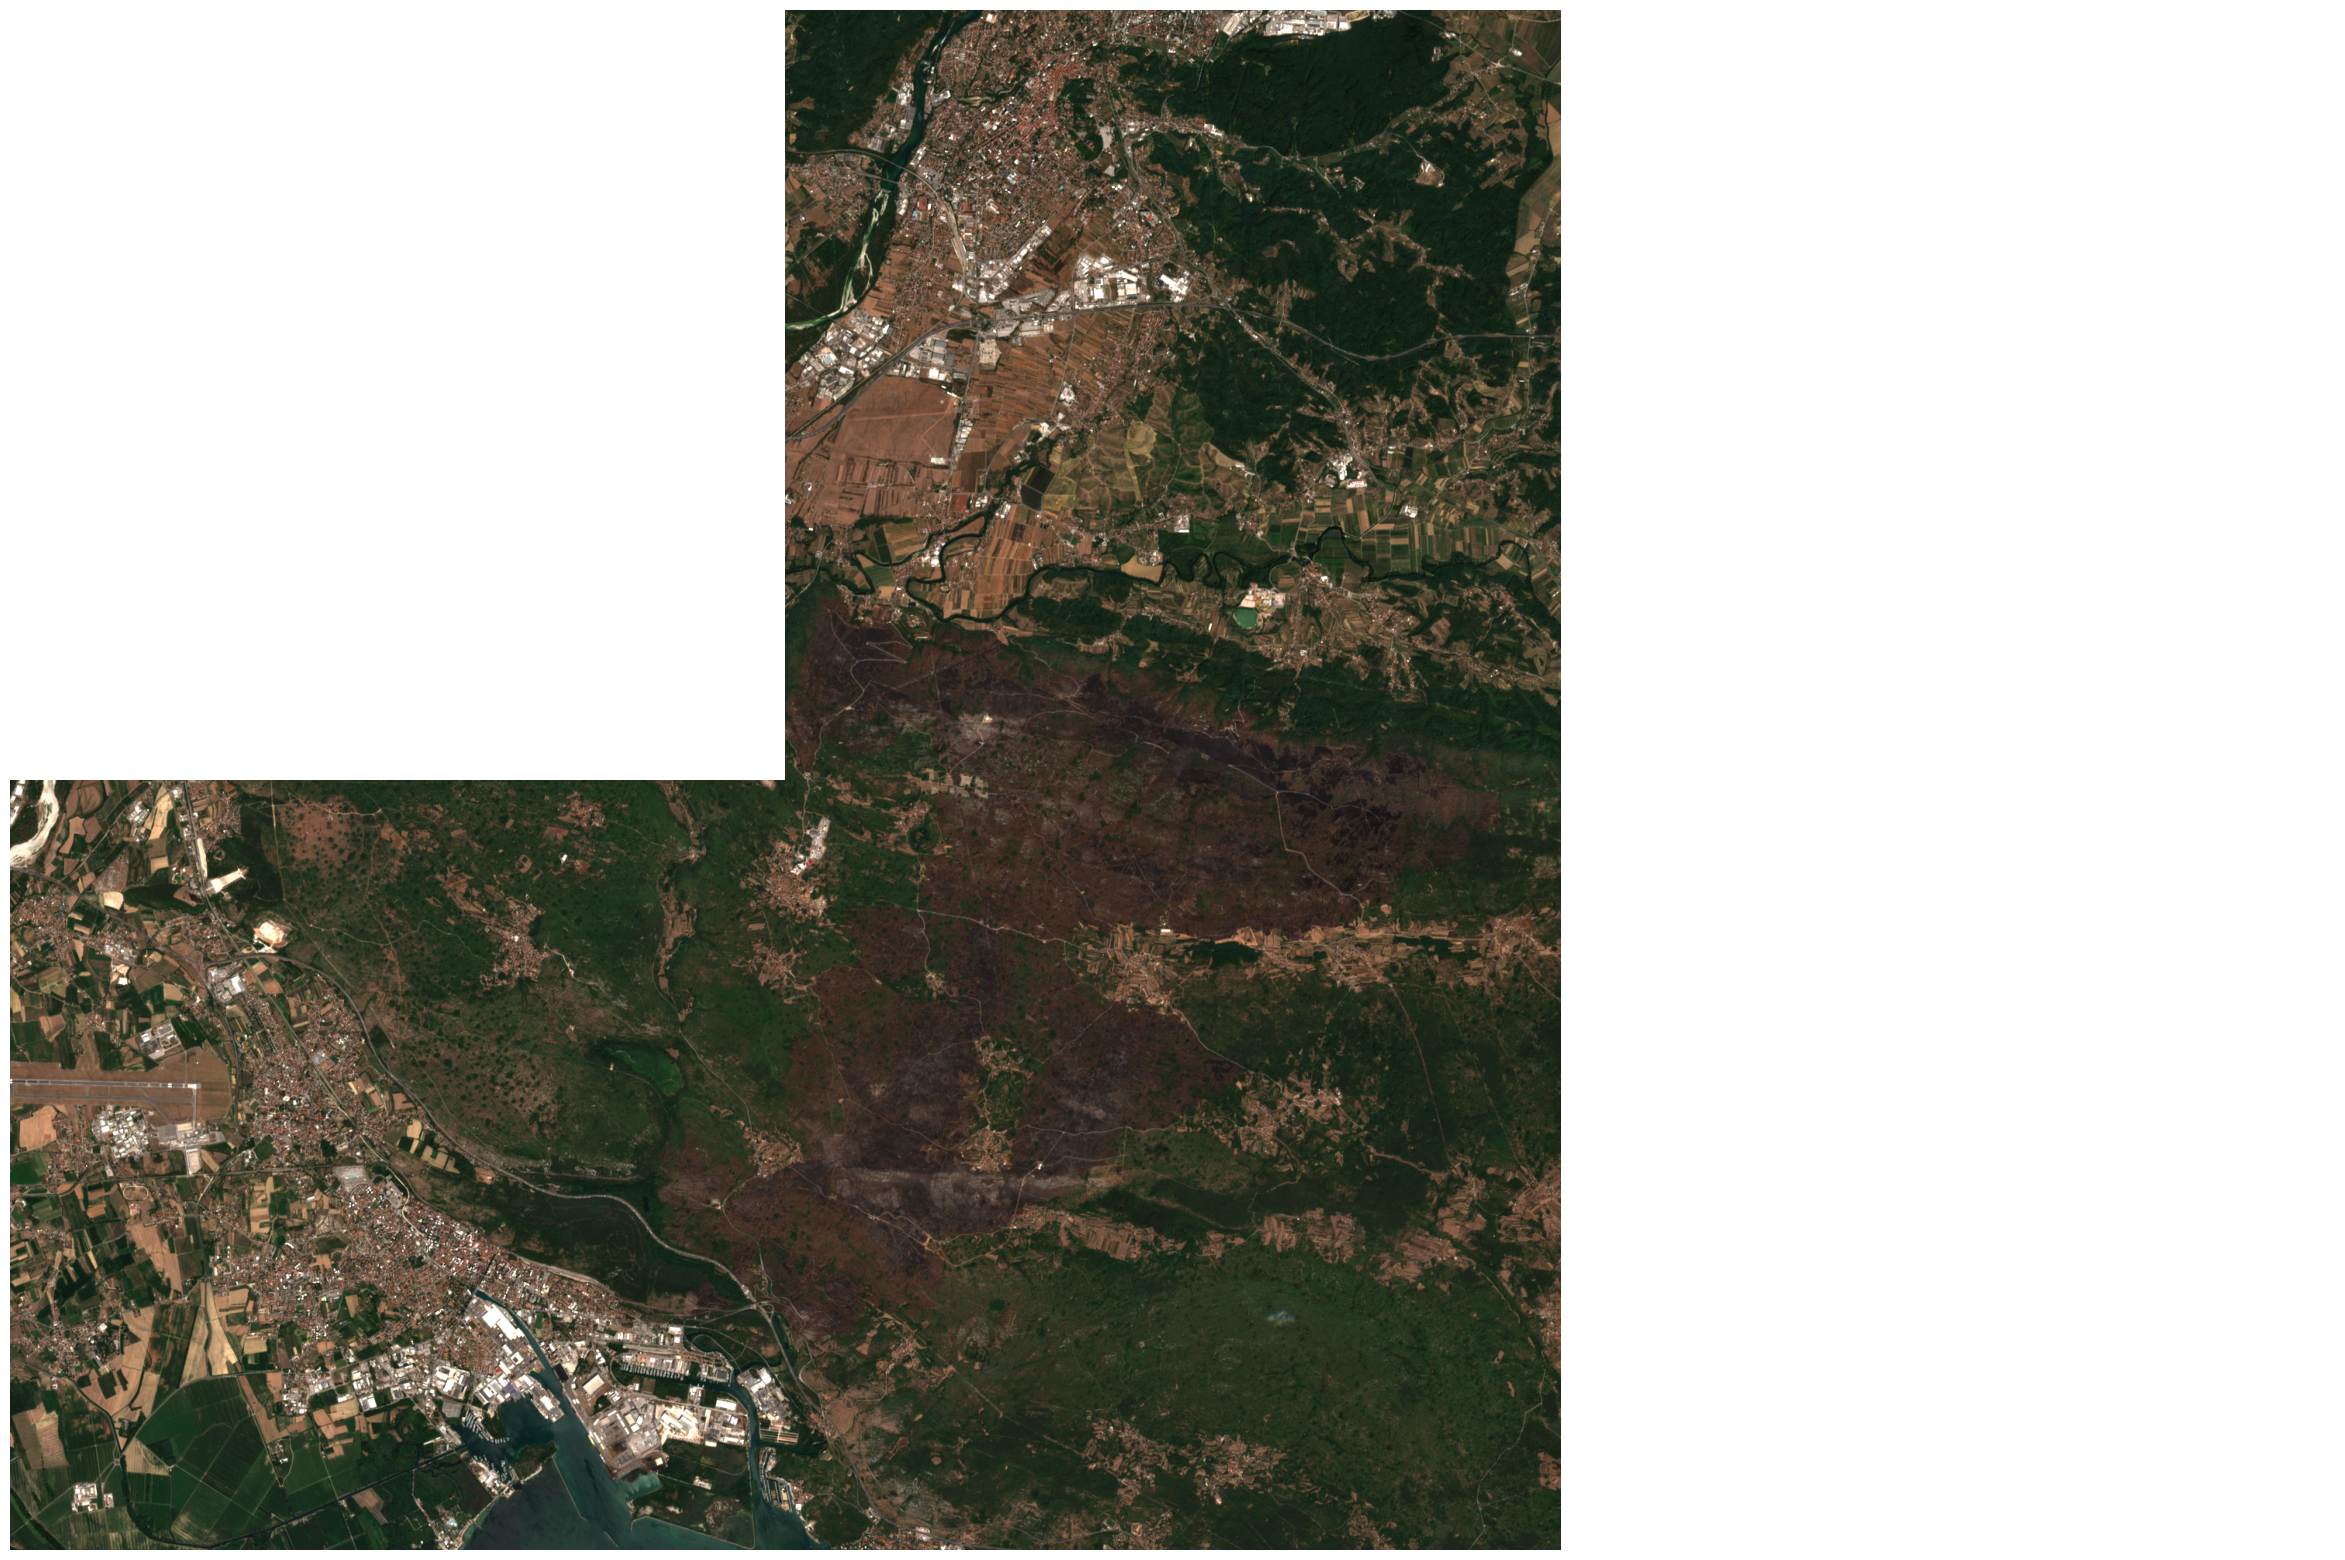

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))

for eop_name, _ in tqdm(download_pipeline.area_manager.get_patch_list()):
    eopatch_path = os.path.join(storage_manager.get_folder("data", full_path=True), eop_name)
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    j, i = int(eop_name.split("-")[4]), int(eop_name.split("-")[6])
    ax = axs[1 - i][j]
    ax.imshow(3.5 * eopatch.data["BANDS"][-1][..., [3, 2, 1]])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    ax.set_axis_off()
    del eopatch

[ax.set_axis_off() for ax in axs.flatten()]

fig.subplots_adjust(wspace=0, hspace=0)

  0%|          | 0/3 [00:00<?, ?it/s]

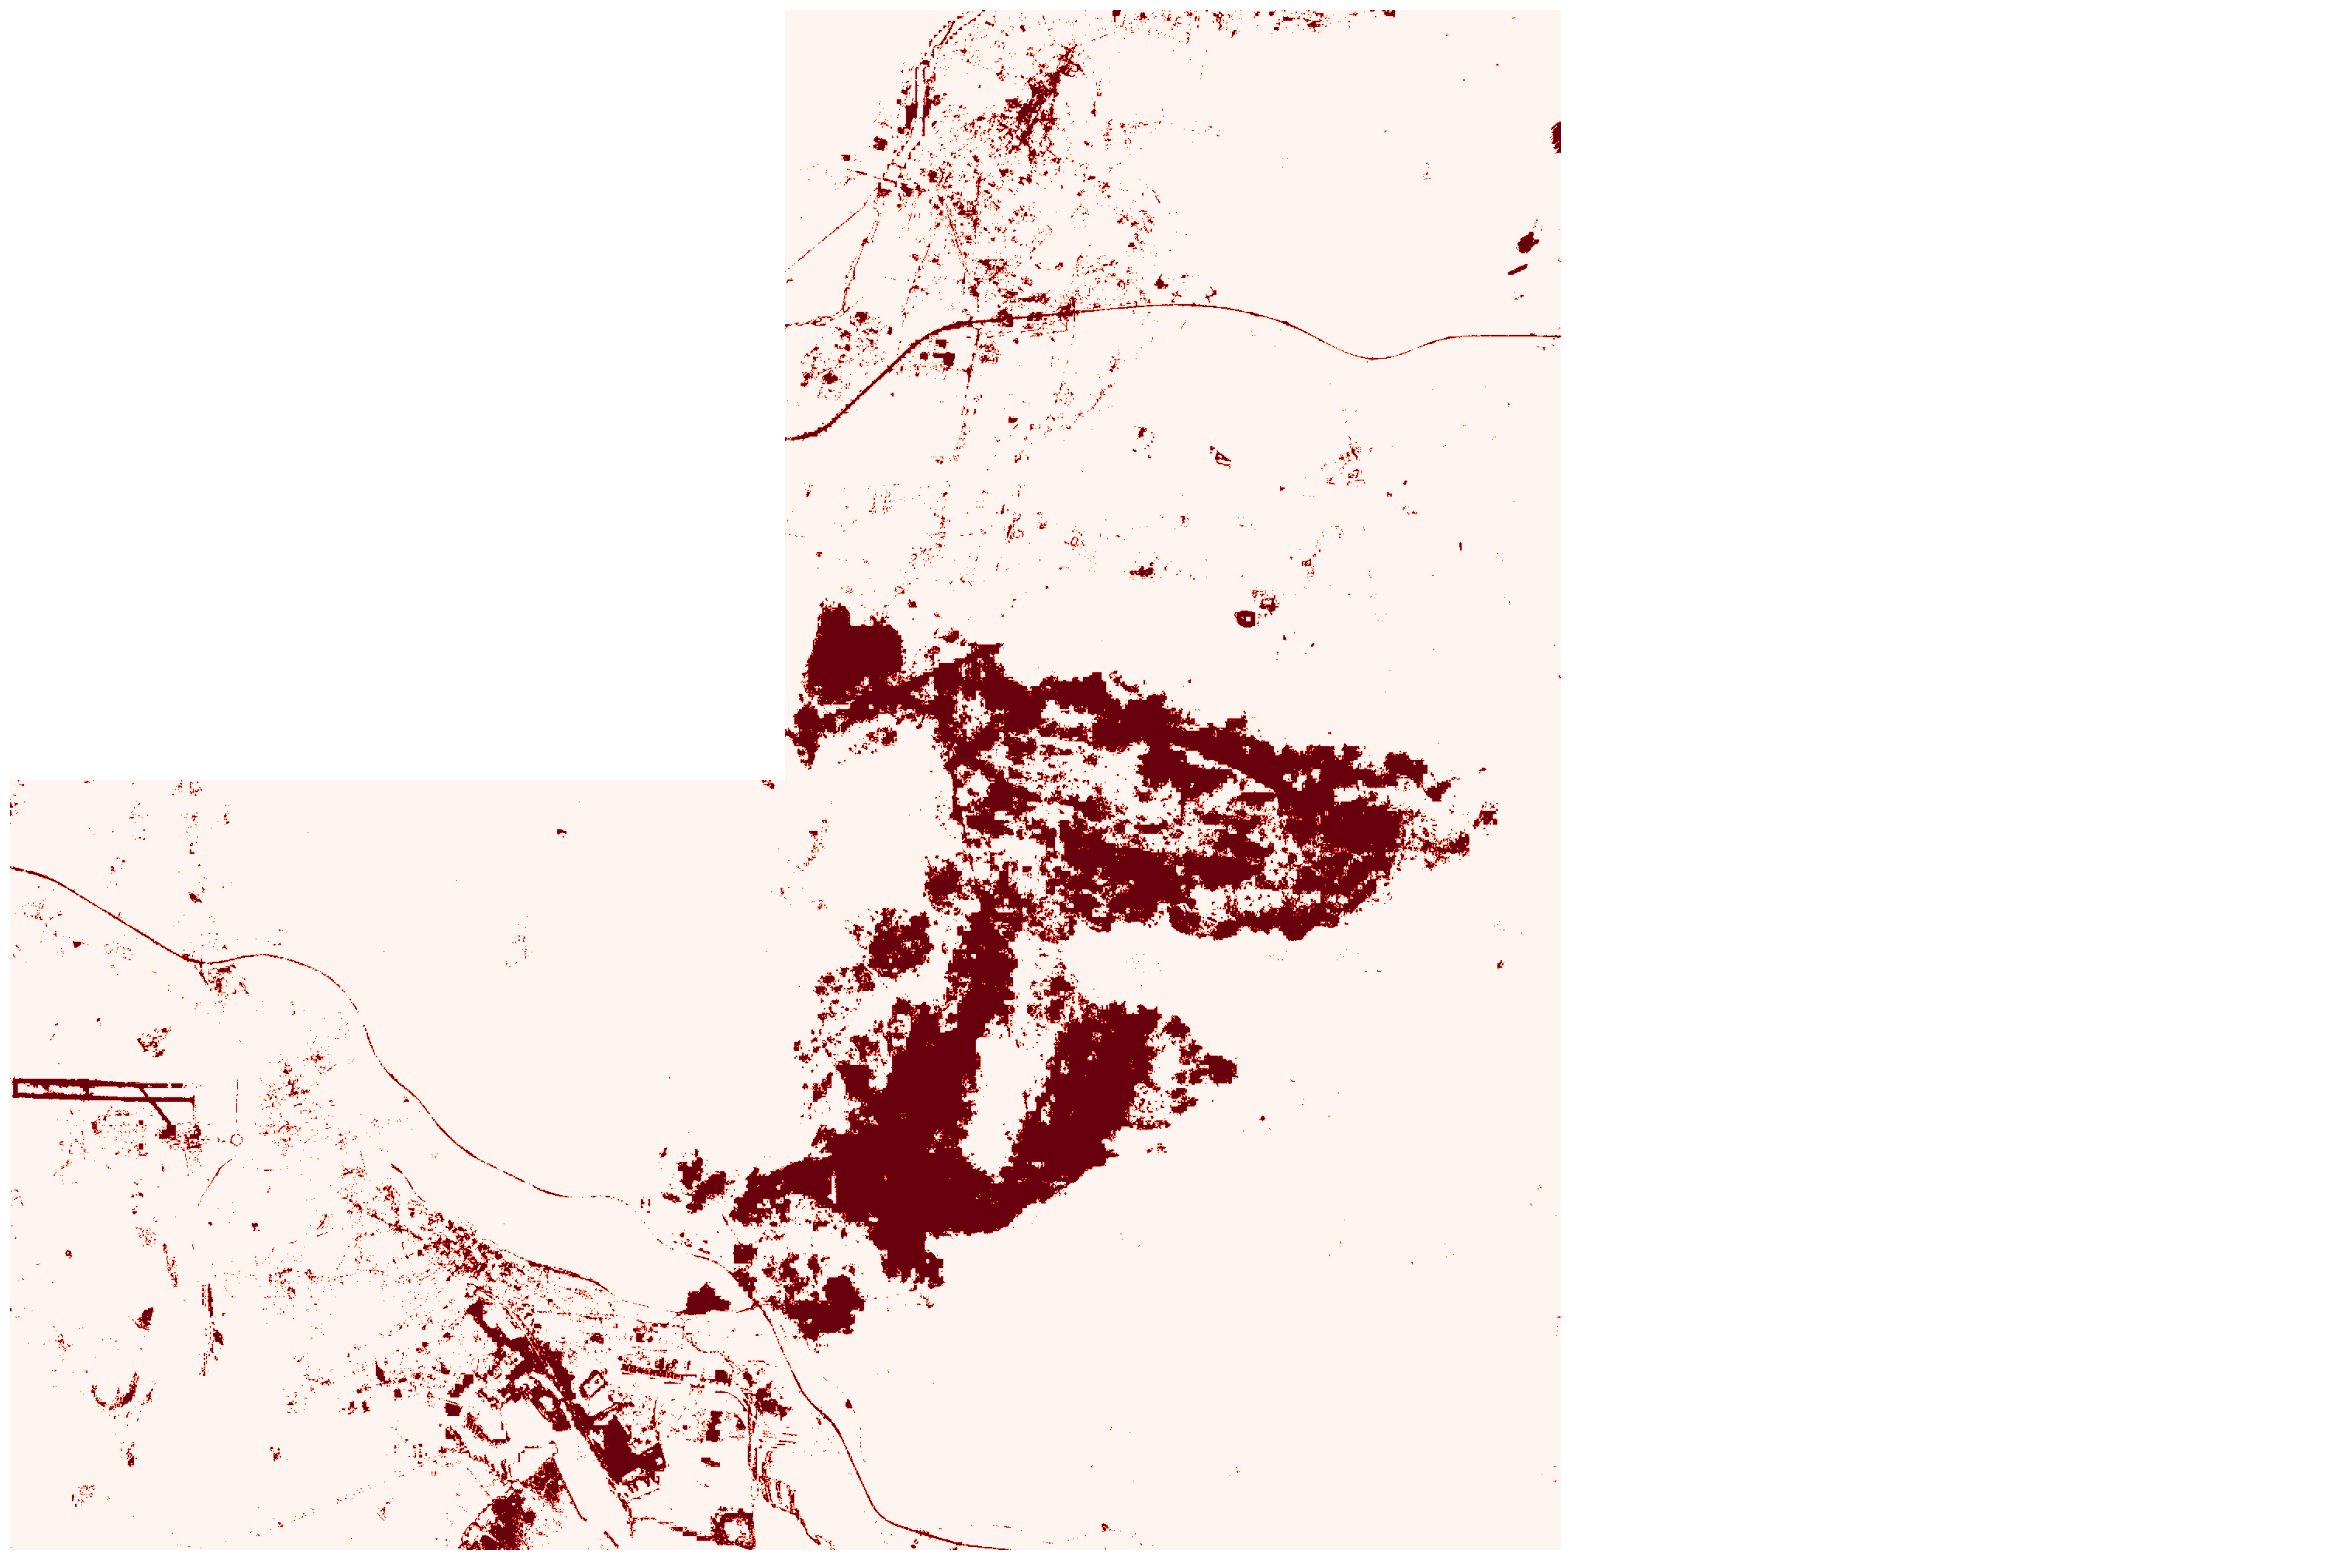

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))

for eop_name, _ in tqdm(download_pipeline.area_manager.get_patch_list()):
    eopatch_path = os.path.join(storage_manager.get_folder("predictions", full_path=True), eop_name)
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    j, i = int(eop_name.split("-")[4]), int(eop_name.split("-")[6])
    ax = axs[1 - i][j]
    ax.imshow(eopatch.mask["prediction"][-1].squeeze(), vmin=0, vmax=1, cmap="Reds")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    ax.set_axis_off()
    del eopatch

[ax.set_axis_off() for ax in axs.flatten()]

fig.subplots_adjust(wspace=0, hspace=0)